In [1]:
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Activation, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from util import plotScatterDecode, plotProgress, plotCompDecode, plotScatterEncode, addNoise

c:\users\user\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 50
sizeBatch = 32
sizeKernel = 3
dimInter = 64
dimEncode = 2
layer_filters = [16, 32]
factNoise = 0
nameOptim = 'adam'

## Load the datasets

In [3]:
(xTrain, _), (xTest, yTest) = mnist.load_data()
sizeDigit = xTrain.shape[1]
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])

xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.

xTrain = np.reshape(xTrain, [-1, sizeDigit, sizeDigit, 1])
xTest = np.reshape(xTest, [-1, sizeDigit, sizeDigit, 1])
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)

print(xTrain.shape)
print(xTest.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Construct the autoencoder

In [4]:
inputs = Input(shape=(sizeDigit, sizeDigit, 1))  # adapt this if using `channels_first` image data format
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=sizeKernel,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
x = Dense(dimInter, activation='relu')(x)
latent = Dense(dimEncode, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
inputLatent = Input(shape=(dimEncode,), name='decoder_input')
x = Dense(dimInter, activation='relu')(inputLatent)
x = Dense(shape[1] * shape[2] * shape[3])(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=sizeKernel,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=sizeKernel,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(inputLatent, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                100416    
_________________________________________________________________
latent_vector (Dense)        (None, 2)                 130       
Total params: 105,346
Trainable params: 105,346
Non-trainable params: 0
_________________________________________________________________
____

## Construct the encoder and decoder

In [5]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 2)                 105346    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         116129    
Total params: 221,475
Trainable params: 221,475
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [6]:
autoencoder.compile(optimizer=nameOptim, loss='binary_crossentropy')

# Train the autoencoder
tic = time()
history = autoencoder.fit(xTrainNoise, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 22s 359us/step - loss: 0.2172 - val_loss: 0.1932
Epoch 2/50
60000/60000 [==============================] - 19s 322us/step - loss: 0.1895 - val_loss: 0.1864
Epoch 3/50
60000/60000 [==============================] - 20s 331us/step - loss: 0.1844 - val_loss: 0.1827
Epoch 4/50
60000/60000 [==============================] - 20s 328us/step - loss: 0.1813 - val_loss: 0.1817
Epoch 5/50
60000/60000 [==============================] - 20s 328us/step - loss: 0.1794 - val_loss: 0.1790
Epoch 6/50
60000/60000 [==============================] - 20s 330us/step - loss: 0.1777 - val_loss: 0.1783
Epoch 7/50
60000/60000 [==============================] - 20s 327us/step - loss: 0.1765 - val_loss: 0.1768
Epoch 8/50
60000/60000 [==============================] - 20s 327us/step - loss: 0.1755 - val_loss: 0.1762
Epoch 9/50
60000/60000 [==============================] - 20s 327us/step - loss: 0.1748 - val_

## Show the historical training progress 

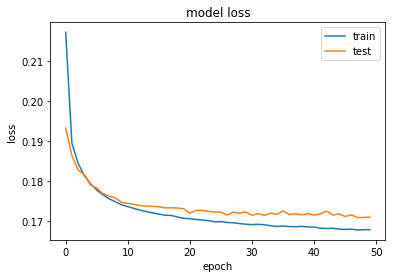

In [7]:
# print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTestNoise)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

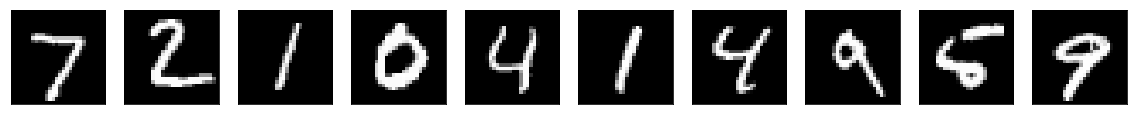

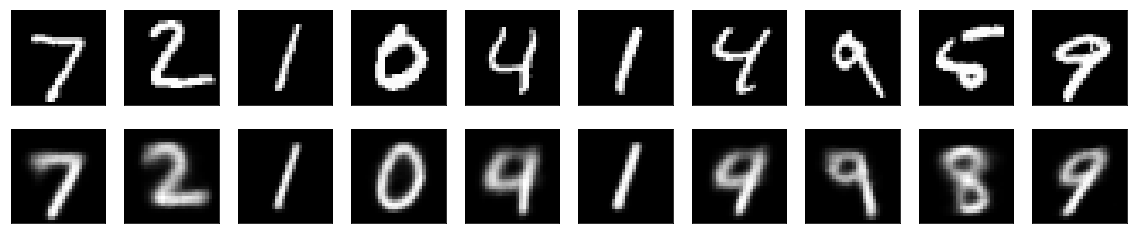

In [9]:
plotCompDecode(xTest, decodeTest, xNoise=xTestNoise)

## Plot the scatter of the encoding space

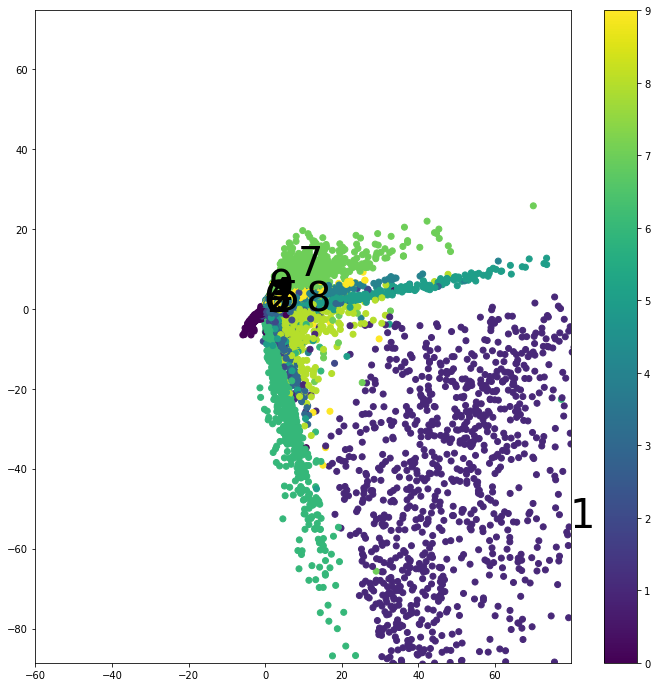

In [10]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

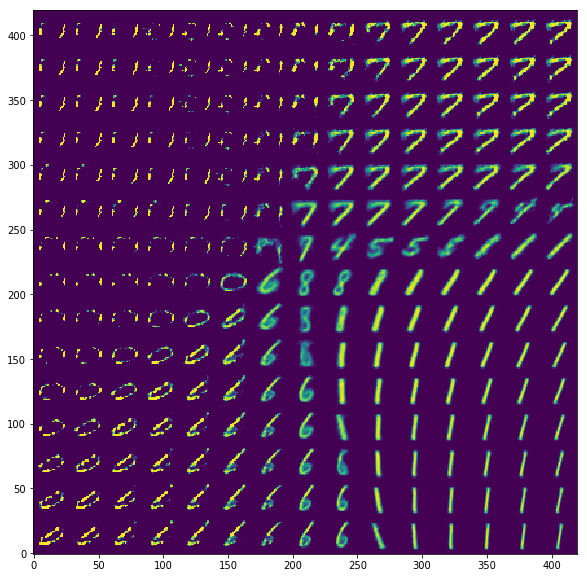

In [11]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, sizeDigit, xlim, ylim)

In [12]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

962.2610068321228 0.1678168867111206 0.1709501528263092 -0.038303744


In [13]:
(xTrain, _), (xTest, yTest) = mnist.load_data()

In [14]:
timeTrain = 3